In [2]:
# Core Libraries
import pandas as pd
import random
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import sweetviz as sv
from tqdm import tqdm

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensemble
from sklearn.ensemble import VotingRegressor, StackingRegressor

# Others
import warnings
warnings.filterwarnings('ignore')

In [4]:
# dataset size use (full data too large for computation. adjust accordingly)
sample_frac = 0.01

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

# reduce decimal place for selected_cols (from 16 to 8. for faster computation)
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'float32'
}

random.seed(42)
df = pd.read_csv(r".\data\train.csv", 
                 usecols=selected_cols, 
                 dtype=dtypes, 
                 parse_dates=['pickup_datetime'], 
                 skiprows=skip_row)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(6)
memory usage: 16.9 MB


In [8]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.810809,11.622035,8.041162,12.065184,9.226158,1.341986
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [10]:
df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1.0
1,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2.0


In [12]:
test_df = pd.read_csv(r'.\data\test.csv',
                     dtype=dtypes,
                     parse_dates=['pickup_datetime'])

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(5), object(1)
memory usage: 348.7+ KB


In [16]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042799,0.033542,0.039093,0.035436,1.278756
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [18]:
test_df.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1.0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1.0


                                             |          | [  0%]   00:00 -> (? left)


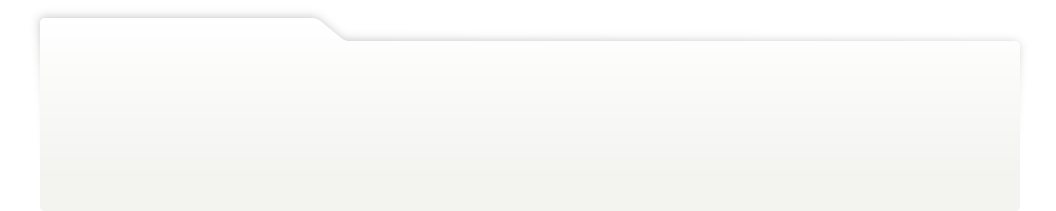
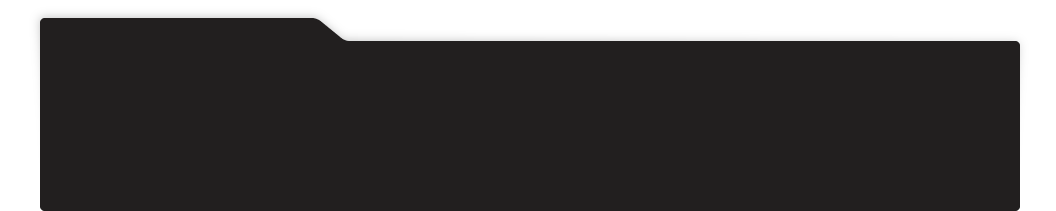
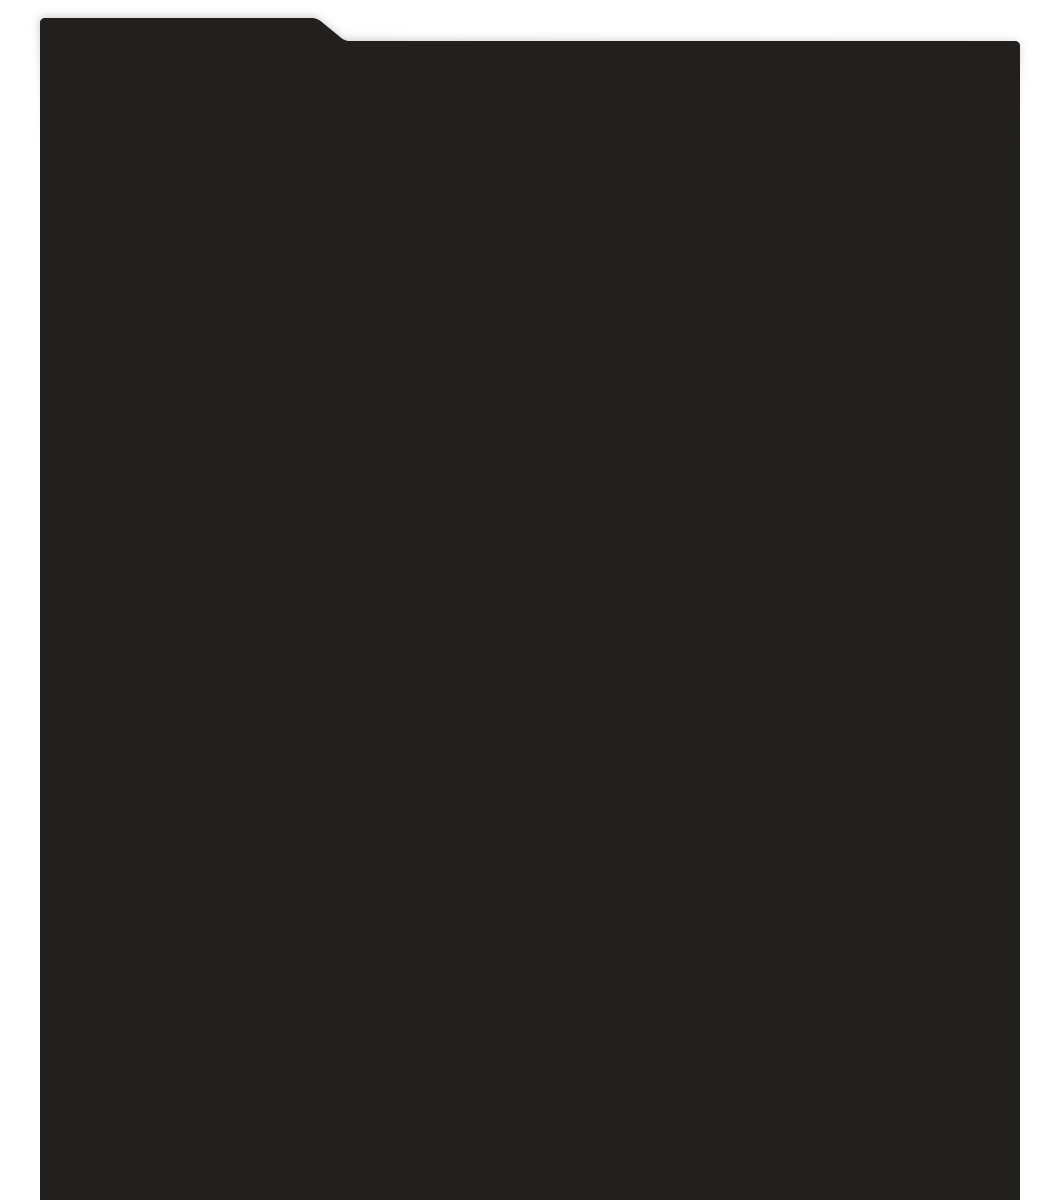
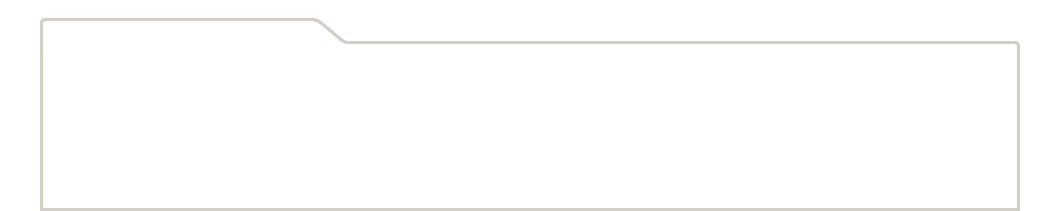
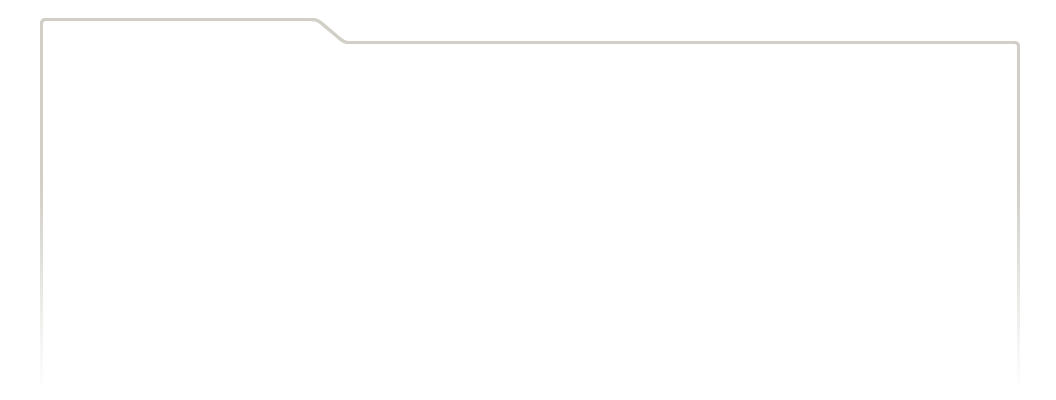
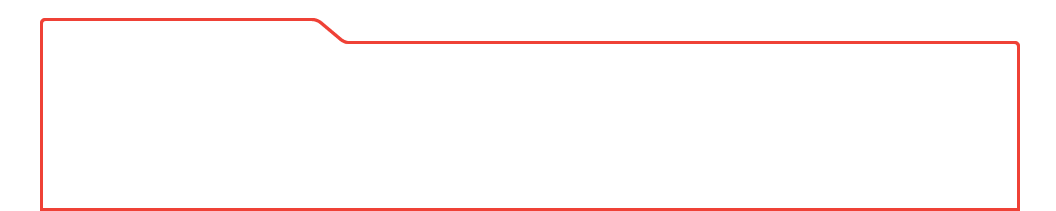
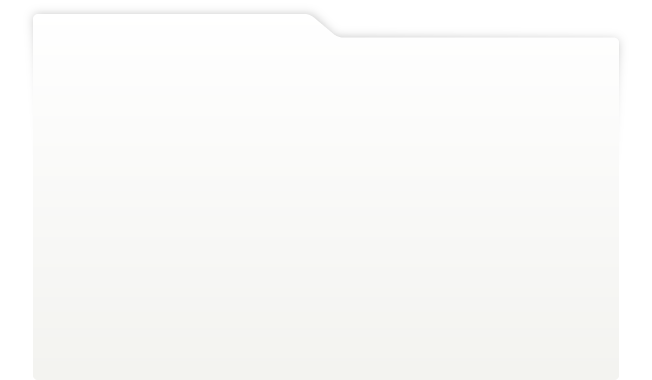
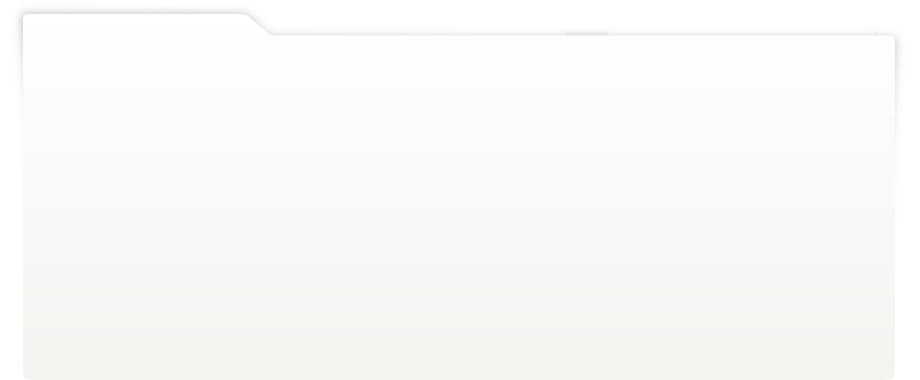
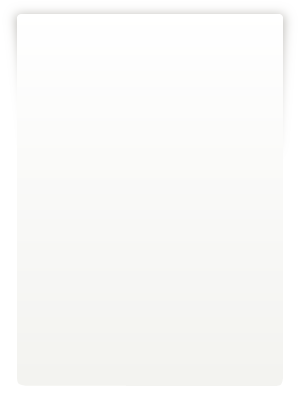
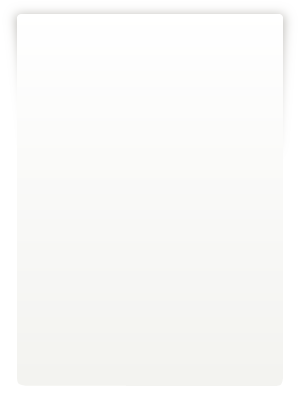
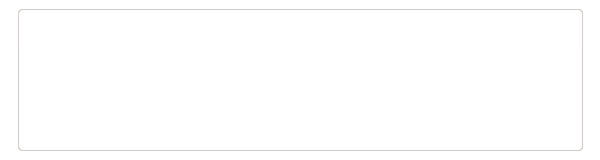
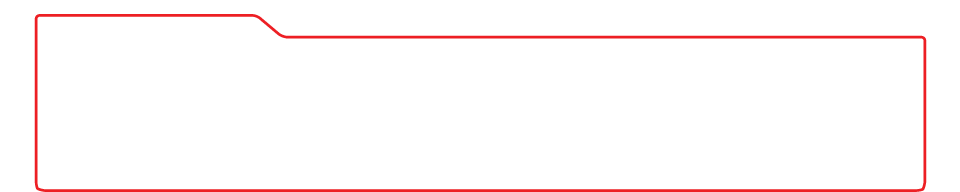
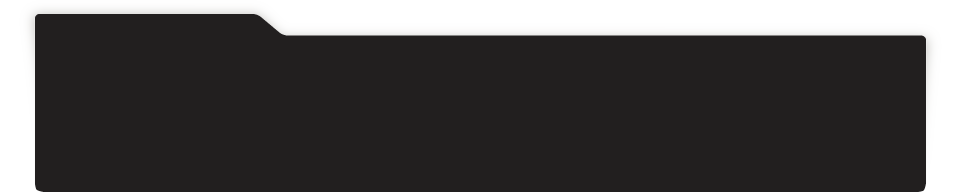
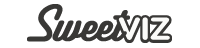
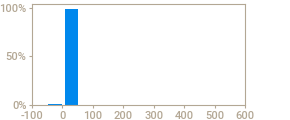
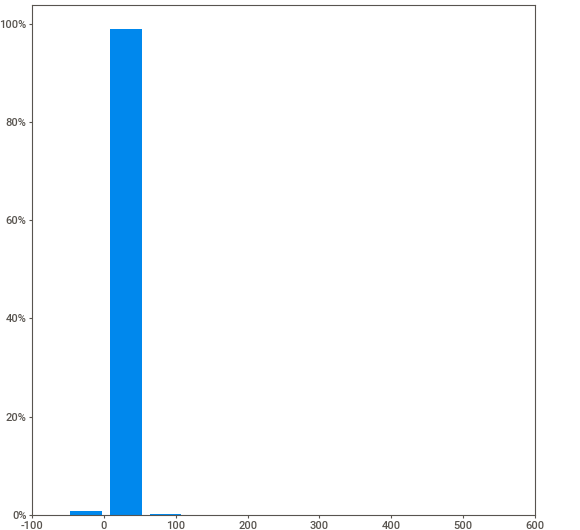
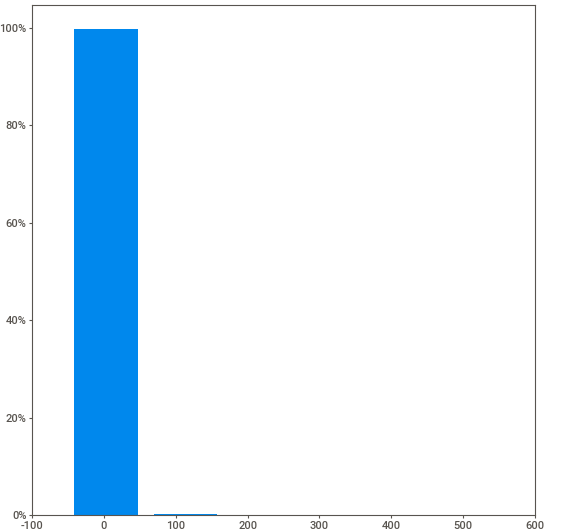
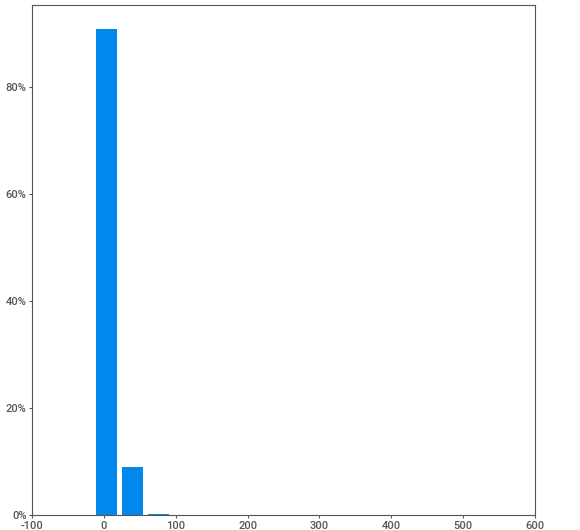
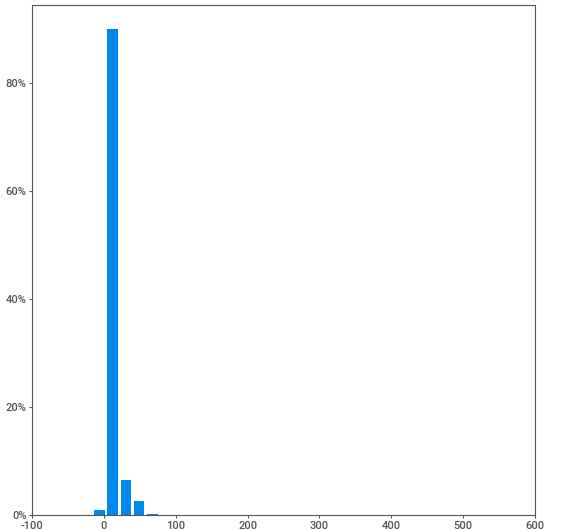
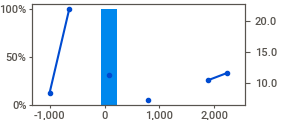
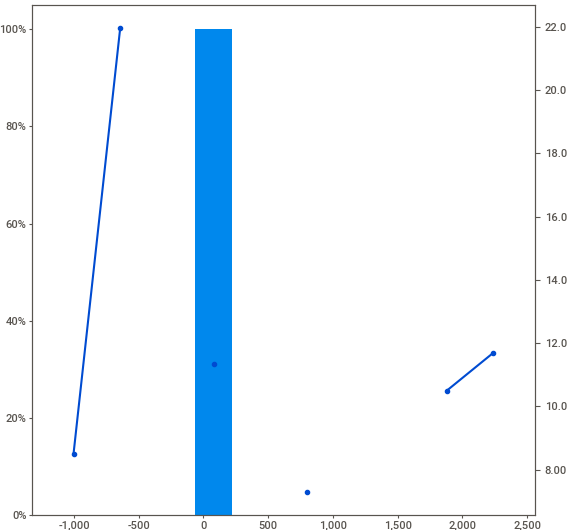
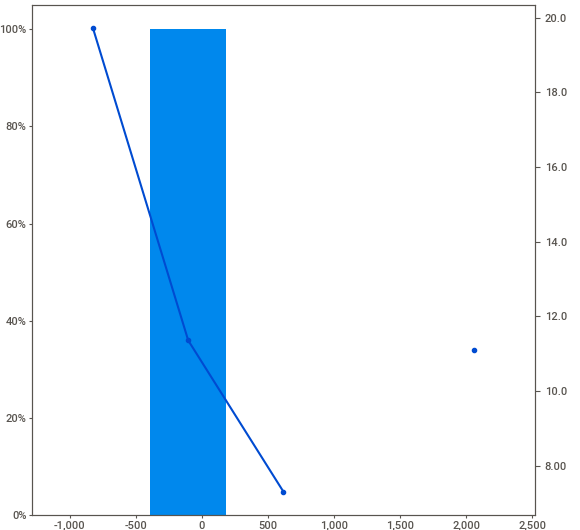
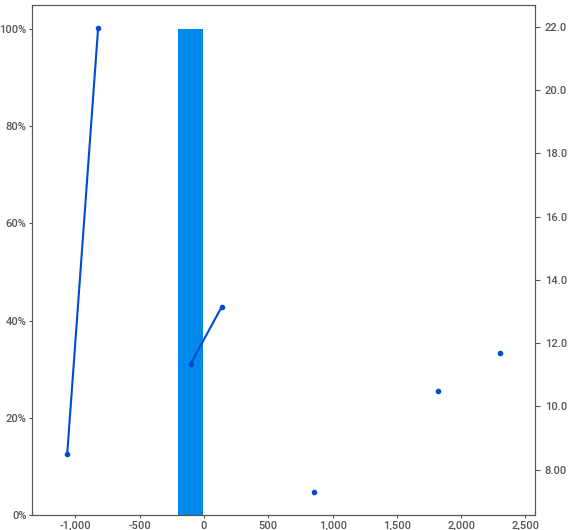
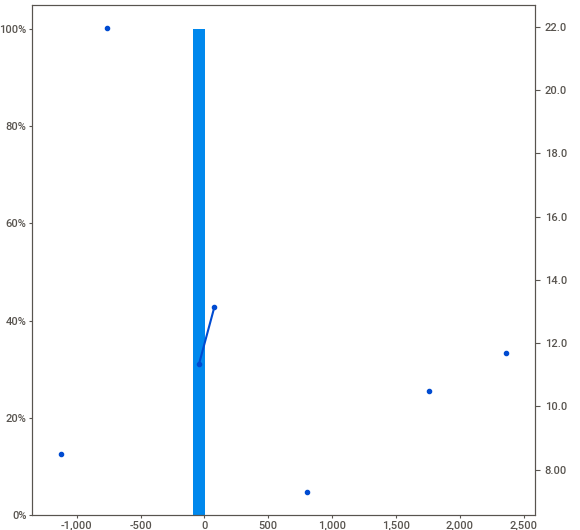
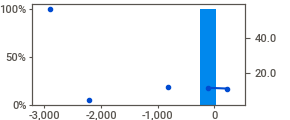
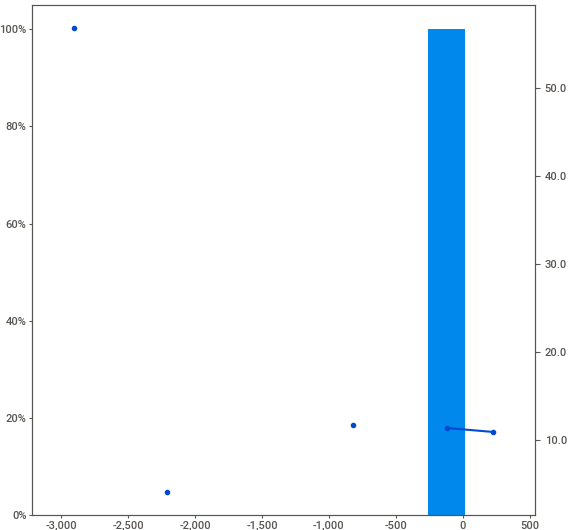
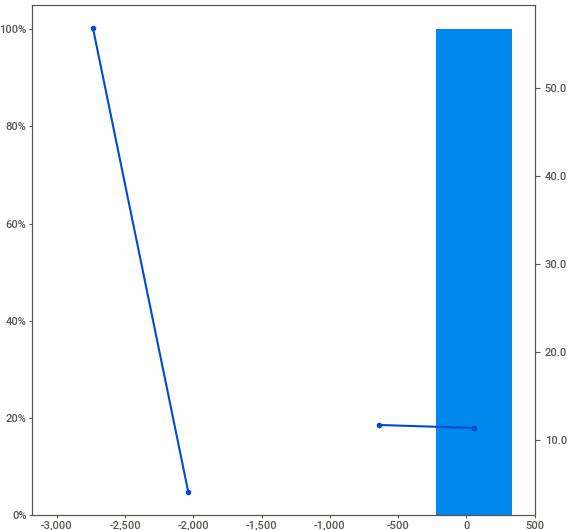
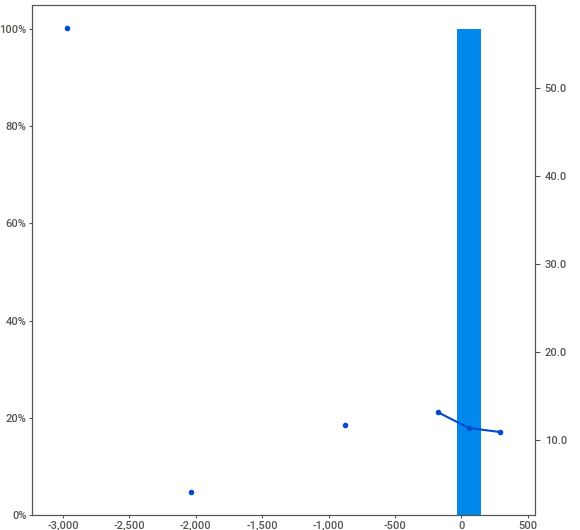
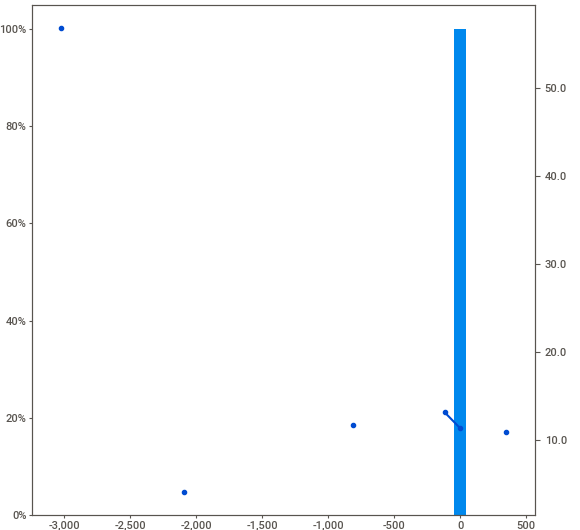
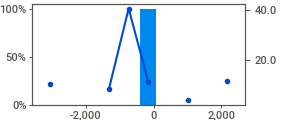
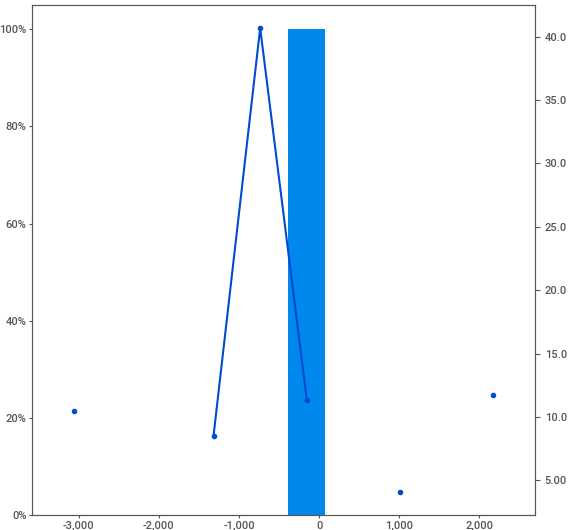
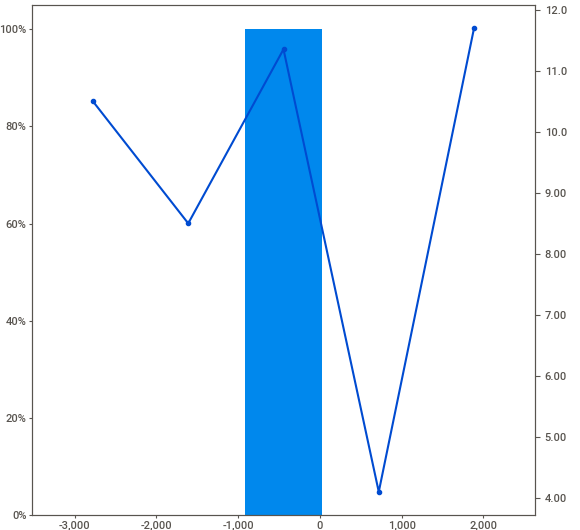
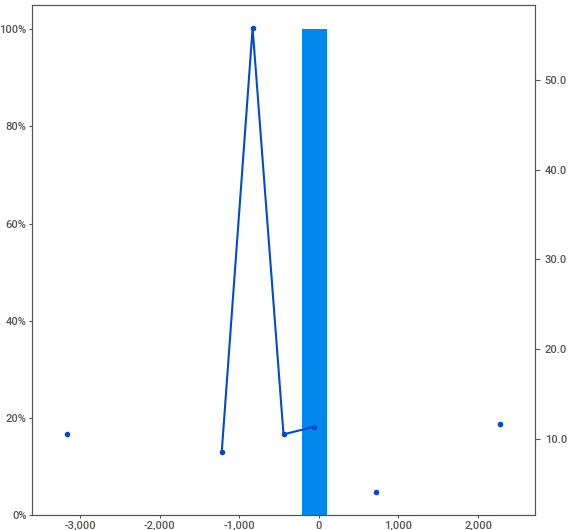
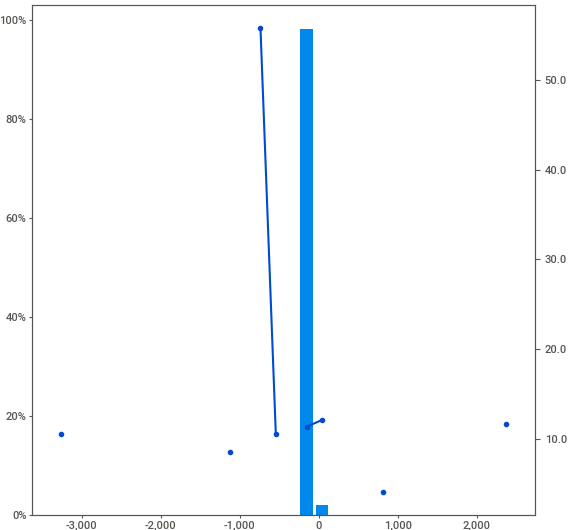
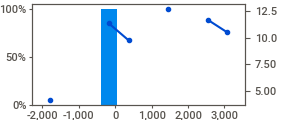
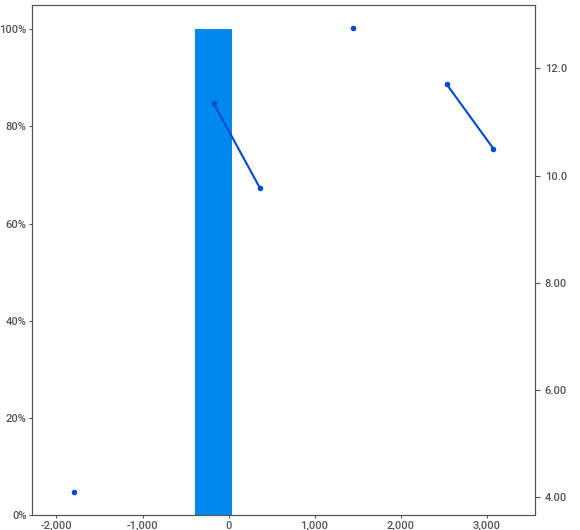
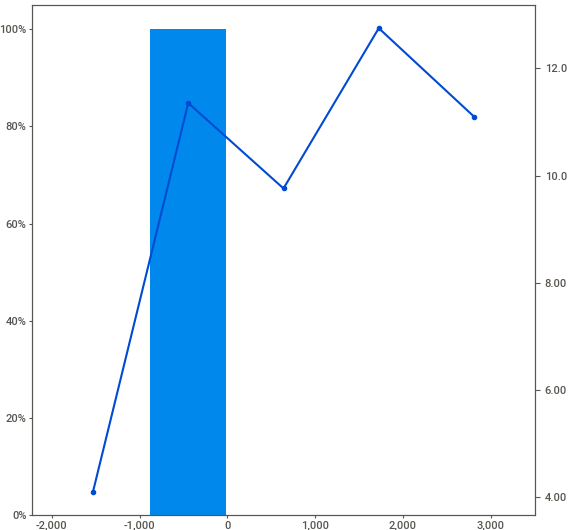
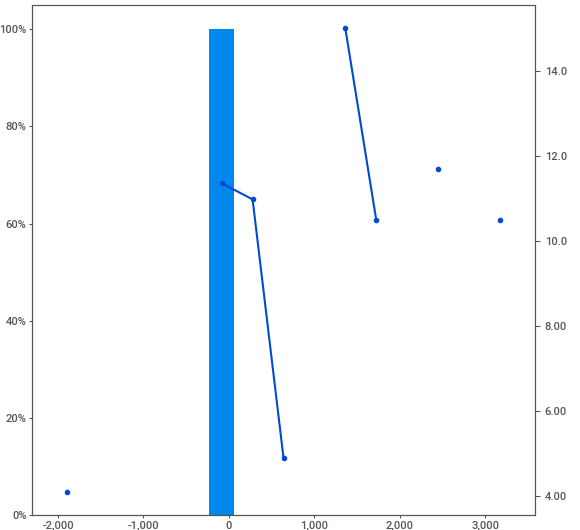
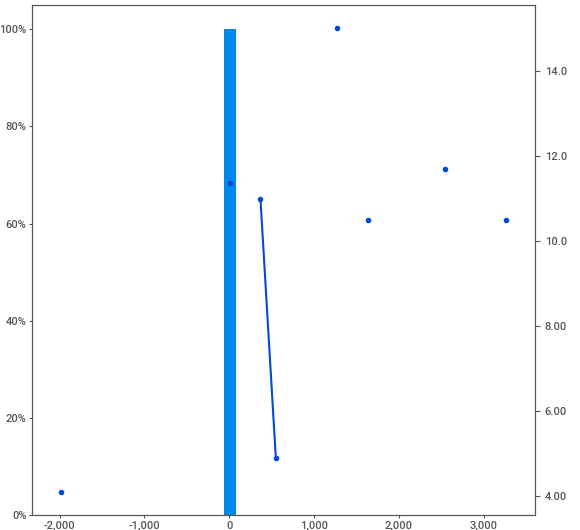
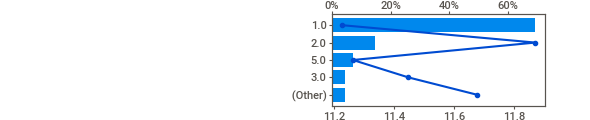
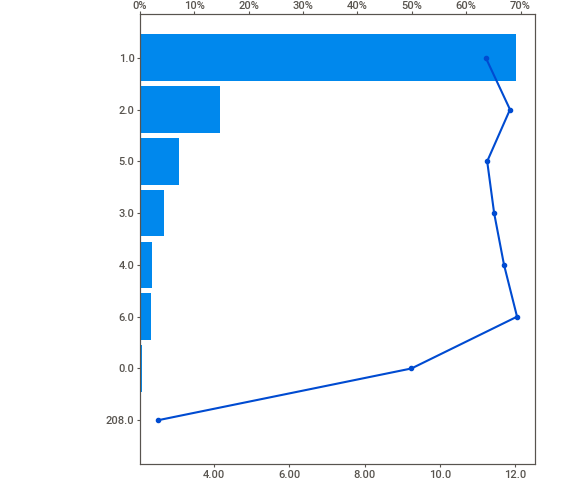
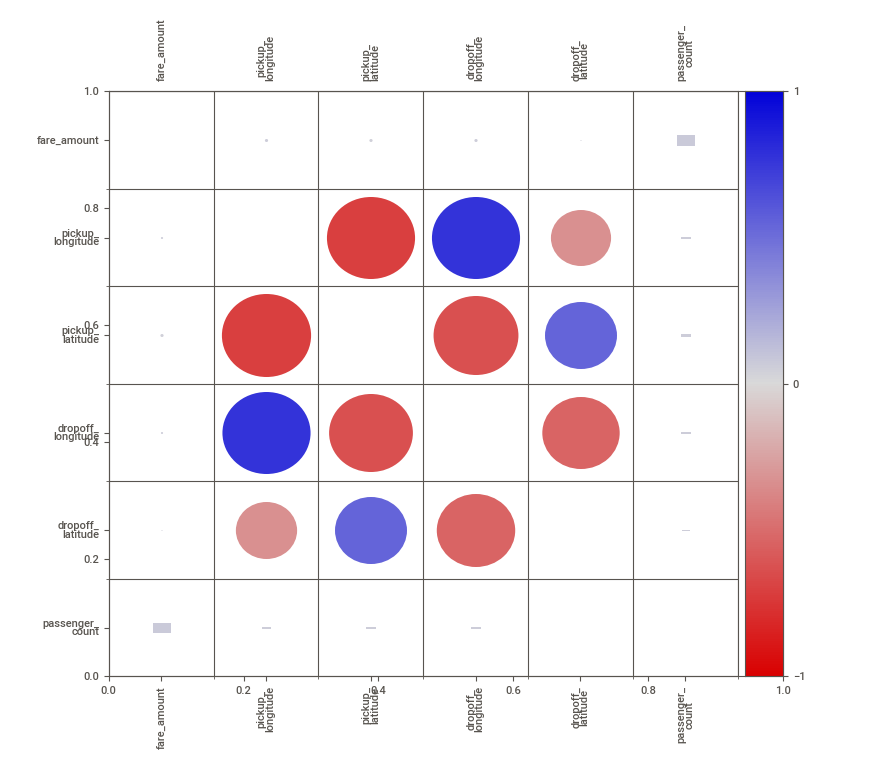
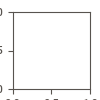

In [20]:
my_report = sv.analyze(df,'fare_amount')
my_report.show_notebook(w='100%', h='full')

In [22]:
# Split train & validation set
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print('train_df.shape: ',train_df.shape)
print('val_df.shape: ',val_df.shape)

train_df.shape:  (441960, 7)
val_df.shape:  (110490, 7)


In [24]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [26]:
# Set Inputs and Target
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
target_col = 'fare_amount'

# Train,Validation & Test cols
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

test_inputs = test_df[input_cols]

In [28]:
# Train with harcoded model as Baseline
class MeanRegressor():
    def fit(self, inputs, targets):
        self.mean = targets.mean()

    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

mean_model = MeanRegressor()

In [30]:
mean_model.fit(train_inputs, train_targets)
mean_model.mean

11.354714

In [32]:
val_preds = mean_model.predict(val_inputs)
val_preds

array([11.354714, 11.354714, 11.354714, ..., 11.354714, 11.354714,
       11.354714], dtype=float32)

In [34]:
# Feature Engineering

In [36]:
# Extract date details
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

add_dateparts(train_df, 'pickup_datetime')
add_dateparts(val_df, 'pickup_datetime')
add_dateparts(test_df, 'pickup_datetime')

In [38]:
train_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4.0,2015,4,12,6,3
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1.0,2011,1,26,2,19


In [40]:
# Add distance between Pickup and Drop
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

add_trip_distance(train_df)
add_trip_distance(val_df)
add_trip_distance(test_df)

In [42]:
train_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4.0,2015,4,12,6,3,1.323411
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1.0,2011,1,26,2,19,0.000000


In [44]:
# Add distance from Popular Landmark
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])

for a_df in [train_df, val_df, test_df]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

In [46]:
train_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4.0,2015,4,12,6,3,1.323411,20.24140,9.556355,17.564440,4.300385,4.261684
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1.0,2011,1,26,2,19,0.000000,20.39752,11.641132,15.713149,6.614004,1.900218


In [48]:
# remove outliers in train_df & val_df. Use test_df dataset as benchmark.

#fare_amount: 1 to 500
#longitudes: -75 to -72
#latitudes: 40 to 42
#passenger_count: 1 to 6

def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

train_df = remove_outliers(train_df)
val_df = remove_outliers(val_df)

In [50]:
train_df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4.0,2015,4,12,6,3,1.323411,20.24140,9.556355,17.564440,4.300385,4.261684
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724579,1.0,2011,1,26,2,19,0.000000,20.39752,11.641132,15.713149,6.614004,1.900218


In [52]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000
mean,11.347895,-73.975121,40.750957,-73.974342,40.751324,1.690374,2011.737524,6.266821,15.732629,3.035066,13.506704,3.330515,20.913206,9.693021,18.474831,4.497471,5.967942
std,9.713450,0.045488,0.093586,0.045281,0.094919,1.308070,1.862116,3.436091,8.697833,1.950459,6.516894,3.741461,3.104939,3.091174,3.758699,3.804707,3.994604
min,1.000000,-74.839172,40.063896,-74.843079,40.054207,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.305583,0.116402,0.129245,0.031195,0.009281
25%,6.000000,-73.992249,40.736530,-73.991592,40.735497,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.253382,20.519000,8.323345,16.477411,2.140186,3.585761
50%,8.500000,-73.982101,40.753319,-73.980606,40.753765,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.153255,21.173625,9.520789,17.958796,3.720862,5.488690
75%,12.500000,-73.968399,40.767437,-73.965401,40.768360,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.917217,21.898378,10.986174,19.785087,5.906888,7.641019
max,400.000000,-72.982796,41.787712,-72.935562,41.806301,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,113.474625,130.364136,114.624855,125.375267,114.114685,121.605186


In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431098 entries, 353352 to 121958
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   fare_amount              431098 non-null  float32            
 1   pickup_datetime          431098 non-null  datetime64[ns, UTC]
 2   pickup_longitude         431098 non-null  float32            
 3   pickup_latitude          431098 non-null  float32            
 4   dropoff_longitude        431098 non-null  float32            
 5   dropoff_latitude         431098 non-null  float32            
 6   passenger_count          431098 non-null  float32            
 7   pickup_datetime_year     431098 non-null  int32              
 8   pickup_datetime_month    431098 non-null  int32              
 9   pickup_datetime_day      431098 non-null  int32              
 10  pickup_datetime_weekday  431098 non-null  int32              
 11  pickup_dateti

In [56]:
# Always parquet after cleaning data/feature engineering

# train_df.to_parquet('train_df.parquet')
# val_df.to_parquet('val_df.parquet')
# test_df.to_parquet('test_df.parquet')

# train_df = pd.read_parquet(train_df)
# val_df = pd.read_parquet(val_df)
# test_df = pd.read_parquet(test_df)

In [58]:
# Reassign input & target cols
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']
target_col = 'fare_amount'

train_inputs = train_df[input_cols]
train_target = train_df[target_col]

val_inputs = val_df[input_cols]
val_target = val_df[target_col]

test_inputs = test_df[input_cols]

In [60]:
train_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431098 entries, 353352 to 121958
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   pickup_longitude         431098 non-null  float32
 1   pickup_latitude          431098 non-null  float32
 2   dropoff_longitude        431098 non-null  float32
 3   dropoff_latitude         431098 non-null  float32
 4   passenger_count          431098 non-null  float32
 5   pickup_datetime_year     431098 non-null  int32  
 6   pickup_datetime_month    431098 non-null  int32  
 7   pickup_datetime_day      431098 non-null  int32  
 8   pickup_datetime_weekday  431098 non-null  int32  
 9   pickup_datetime_hour     431098 non-null  int32  
 10  trip_distance            431098 non-null  float32
 11  jfk_drop_distance        431098 non-null  float32
 12  lga_drop_distance        431098 non-null  float32
 13  ewr_drop_distance        431098 non-null  float32
 14  met_

In [62]:
# Identify features for impute,scale & encode
numerical_features = [
        'passenger_count', 'pickup_datetime_year',
       'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'
]

In [64]:
#Preprocessor for pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)) 
        ]), numerical_features)
    ])

#Models to train with default hyperparameter
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'GradientBoosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(estimator=DecisionTreeRegressor()),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0)
}

#Creating pipeline
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

In [66]:
results = {}
for name, model in tqdm(models.items(), desc="Evaluating Models"):
    pipeline = create_pipeline(model)
    pipeline.fit(train_inputs, train_target)
    y_pred = pipeline.predict(val_inputs)
    
    rmse = mean_squared_error(val_target, y_pred, squared=False)
    mae = mean_absolute_error(val_target, y_pred)
    r2 = r2_score(val_target, y_pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}

for model_name, metrics in results.items():
    print(f"{model_name}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, R^2={metrics['R^2']:.2f}")

Evaluating Models: 100%|██████████| 6/6 [10:17<00:00, 102.97s/it]

Ridge: RMSE=5.42, MAE=2.42, R^2=0.69
Lasso: RMSE=5.87, MAE=3.05, R^2=0.64
GradientBoosting: RMSE=4.63, MAE=2.24, R^2=0.78
AdaBoost: RMSE=4.65, MAE=1.89, R^2=0.77
XGBoost: RMSE=4.48, MAE=2.03, R^2=0.79
CatBoost: RMSE=4.42, MAE=1.98, R^2=0.80


In [68]:
# Top 3 model CatBoost(1), XGBoost(2), GradientBoost(3)
#CatBoost: RMSE=4.42, MAE=1.98, R^2=0.80
#XGBoost: RMSE=4.48, MAE=2.03, R^2=0.79
#GradientBoosting: RMSE=4.63, MAE=2.24, R^2=0.78

# Worst model Lasso
#Lasso: RMSE=5.87, MAE=3.05, R^2=0.64

In [70]:
#Helper Function to Tune Hyperparameter
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    pipeline = create_pipeline(ModelClass(**params))
    model = pipeline.fit(train_inputs, train_target)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_target, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_target, squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    plt.show()

#basic hyperparameter
basic_params = {
    'random_state': 42,
}

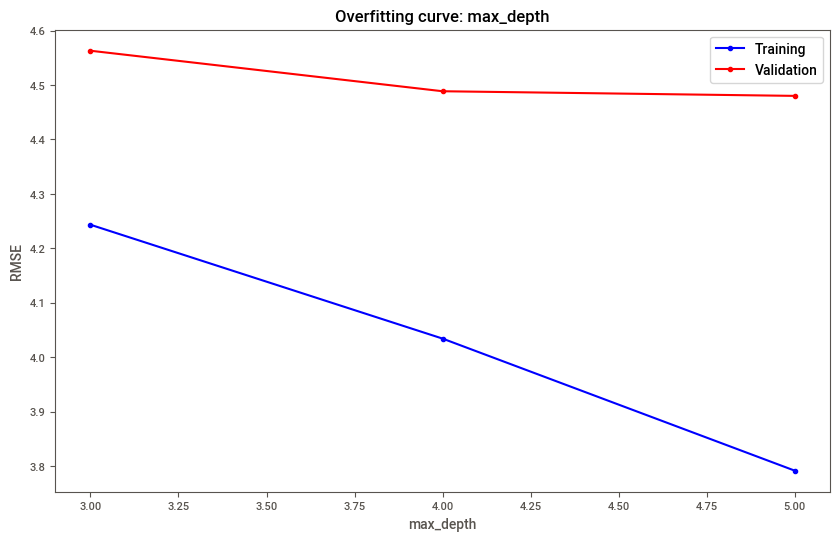

In [72]:
test_param_and_plot(XGBRegressor, 'max_depth', [3, 4, 5], **basic_params)

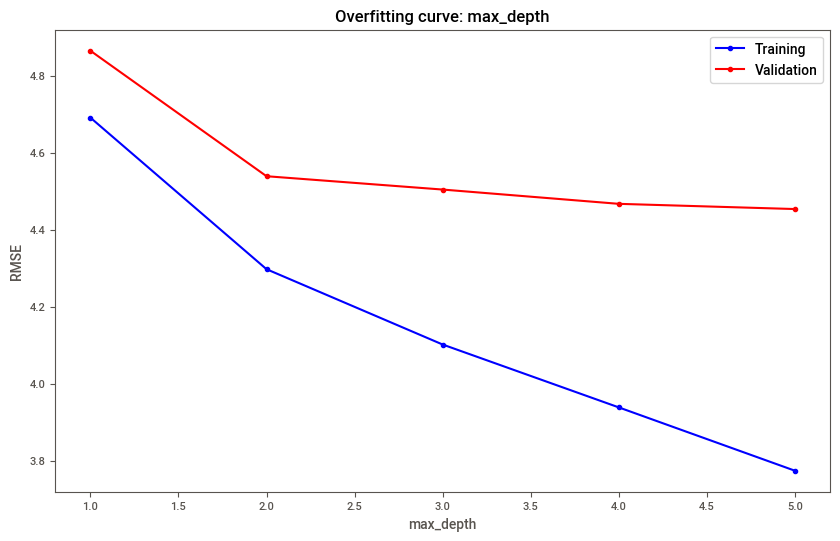

In [74]:
test_param_and_plot(CatBoostRegressor, 'max_depth', [1, 2, 3, 4, 5], verbose=0, **basic_params)

In [76]:
#Ensembling
#Creating pipeline
def create_ensemble_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

#Models for ensembling
best_models = {
    'CatBoost': CatBoostRegressor(verbose=0),
    'XGBoost': XGBRegressor()
}

#StackingRegressor & VotingRegressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('catboost', best_models['CatBoost']),
        ('xgboost', best_models['XGBoost']),
    ],
    final_estimator=XGBRegressor()
)

voting_regressor = VotingRegressor(
    estimators=[
        ('catboost', best_models['CatBoost']),
        ('xgboost', best_models['XGBoost']),
    ]
)

ensemble_models = {
    'Stacking': create_ensemble_pipeline(stacking_regressor),
    'Voting': create_ensemble_pipeline(voting_regressor)
}

In [78]:
ensemble_results = {}
for name, pipeline in tqdm(ensemble_models.items(), desc="Evaluating Ensemble Models"):
    pipeline.fit(train_inputs, train_target)
    y_pred = pipeline.predict(val_inputs)
    
    rmse = mean_squared_error(val_target, y_pred, squared=False)
    mae = mean_absolute_error(val_target, y_pred)
    r2 = r2_score(val_target, y_pred)
    
    ensemble_results[name] = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}

print("\nEnsemble Results:")
for model_name, metrics in ensemble_results.items():
    print(f"{model_name}: RMSE={metrics['RMSE']:.2F}, MAE={metrics['MAE']:.2F}, R^2={metrics['R^2']:.2F}")

Evaluating Ensemble Models: 100%|██████████| 2/2 [01:30<00:00, 45.37s/it]


Ensemble Results:
Stacking: RMSE=4.50, MAE=2.00, R^2=0.79
Voting: RMSE=4.42, MAE=1.98, R^2=0.80


In [80]:
# Voting better than Stacking

In [82]:
#Helper function for final model (voting = CatBoost + XGBoost)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)) 
        ]), numerical_features),
    ])

best_models = {
    'CatBoost': CatBoostRegressor(verbose=0),
    'XGBoost': XGBRegressor(),
}

voting_regressor = VotingRegressor(
    estimators=[
        ('catboost', best_models['CatBoost']),
        ('xgboost', best_models['XGBoost']),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', voting_regressor)
])

pipeline.fit(train_inputs, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  ['passenger_count',
                                                   'pickup_datetime_year',
                                                   'pickup_datetime_month',
                                                   'pickup_datetime_day',
                                                   'pickup_datetime_weekday',
                                                   'pickup_datetime_hour',
                                                   'trip_distance',
                                                   'jfk_drop_distance',
                                                   '...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))])

In [84]:
#Helper function for single input
def predict_fares(input_data):
    input_df = pd.DataFrame([input_data])
    prediction = pipeline.predict(input_df)
    return prediction[0]

In [86]:
train_inputs.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'pickup_datetime_year',
       'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [88]:
example_input = {
    'pickup_longitude': -73.959160,
    'pickup_latitude': 40.780750,
    'dropoff_longitude': -73.969116,
    'dropoff_latitude': 40.761230,
    'passenger_count': 2.0,
    'pickup_datetime_year': 2012,
    'pickup_datetime_month': 10	,
    'pickup_datetime_day': 3,
    'pickup_datetime_weekday': 2,
    'pickup_datetime_hour': 10,
}

In [90]:
# Function autofill trip_distance
def haversine_np2(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

trip_distance = haversine_np2(example_input['pickup_longitude'],example_input['pickup_latitude'],example_input['dropoff_longitude'],example_input['dropoff_latitude'])

# Function autofill drop distance from landmarks
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

def dropoff_distance2(landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    distance = haversine_np2(lon, lat, example_input['dropoff_longitude'], example_input['dropoff_latitude'])
    return distance

example_input2 = {
    'pickup_longitude': example_input['pickup_longitude'],
    'pickup_latitude': example_input['pickup_latitude'],
    'dropoff_longitude': example_input['dropoff_longitude'],
    'dropoff_latitude': example_input['dropoff_latitude'],
    'passenger_count': example_input['passenger_count'],
    'pickup_datetime_year': example_input['pickup_datetime_year'],
    'pickup_datetime_month': example_input['pickup_datetime_month'],
    'pickup_datetime_day': example_input['pickup_datetime_day'],
    'pickup_datetime_weekday': example_input['pickup_datetime_weekday'],
    'pickup_datetime_hour': example_input['pickup_datetime_hour'],
    'trip_distance': trip_distance,
    'jfk_drop_distance': dropoff_distance2('jfk',jfk_lonlat),
    'lga_drop_distance': dropoff_distance2('lga',lga_lonlat),
    'ewr_drop_distance': dropoff_distance2('ewr',ewr_lonlat),
    'met_drop_distance': dropoff_distance2('met',met_lonlat),
    'wtc_drop_distance': dropoff_distance2('wtc',wtc_lonlat)
}

predicted_fares = predict_fares(example_input2)
print(f"Predicted Fares: {predicted_fares:.2F}")

Predicted Fares: 10.13
